In [2]:
"""
Best effort at calculating the % of loans that are returned.

Items that are more than 1 year overdue are considered lost.
"""
import pandas as pd

DATA_DIR = '~/chtl/data/processed/'
items = pd.read_pickle(f'{DATA_DIR}inventory.pkl')
loans = pd.read_pickle(f'{DATA_DIR}loans.pkl')

In [196]:
from datetime import datetime, timedelta

# Items that are either:
#
# * Status: Lost By Member
# * More than 1 year overdue
# * Is Disabled and has Description or Note indicating it was lost, never returned, or stolen
#
# are considered unreturned.
one_year_ago = datetime.now() - timedelta(weeks=52)
very_overdue_item_ids = set(loans[loans['Checked In'].isna() & (loans['Checked Out'] < one_year_ago)]['Item ID'])
items['Lost By Member'] = items['Lost By Member'] | items['Description'].str.contains('Item was lost', case=False, na=False) | items['Admin Notes'].str.contains('Item was lost', case=False, na=False)
items['Very Overdue'] = items['Item ID'].isin(very_overdue_item_ids)
items['Never Returned'] = items['Disabled'] & items['Description'].str.contains('never returned', case=False, na=False) | items['Description'].str.contains('not returned', case=False, na=False) | items['Admin Notes'].str.contains('never returned', case=False, na=False) | items['Admin Notes'].str.contains('not returned', case=False, na=False)
items['Stolen'] = items['Disabled'] & items['Description'].str.contains('stolen', case=False, na=False) | items['Admin Notes'].str.contains('stolen', case=False, na=False)

In [197]:
items['Unreturned'] = items['Very Overdue'] | items['Lost By Member'] | items['Never Returned'] | items['Stolen']
items[items['Unreturned']]

,Item ID,Item Type,Name,Additional Image,Agreement that must be signed to checkout the item,Amount / Fee,Attachment,Author,Between Buffer Days,Categories,...,Lost In Shop,Disabled,Not Fixable,Lost By Member,Wish List,In Maintenance,Very Overdue,Unreturned,Never Returned,Stolen
4,5,Board Games,Cranium,NaN,NaN,NaN,NaN,NaN,0,Sustainable Living,...,False,True,False,False,False,False,False,True,True,False
32,32,Pry Bar,Pry Bar,NaN,NaN,[LOAN:0],NaN,NaN,0,NaN,...,False,False,False,True,False,False,False,True,False,False
34,34,Power Sanders,Power Sander,NaN,NaN,[LOAN:0],NaN,NaN,0,NaN,...,False,True,False,False,False,False,False,True,True,False
36,36,Power Sanders,Power Sander,NaN,NaN,[LOAN:0],NaN,NaN,0,NaN,...,False,True,False,False,False,False,False,True,True,False
46,46,Levels,Level,NaN,NaN,[LOAN:0],NaN,NaN,0,NaN,...,False,True,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,1079,Cordless Tool Batteries,Battery,NaN,NaN,[LOAN:0],NaN,NaN,0,NaN,...,False,False,False,True,False,False,False,True,False,False
7608,81280,Yoga Mats,Yoga Mat,NaN,NaN,NaN,NaN,NaN,0,NaN,...,False,False,False,True,False,False,False,True,False,False
7614,1150,Sewing Machines,Sewing Machine,NaN,NaN,NaN,https://myturn-prod-attachments.s3-us-west-2.a...,NaN,0,Sustainable Living,...,False,False,False,True,False,False,False,True,True,False
7746,81358,Dollies,Medium Dolly,NaN,NaN,[LOAN:0],NaN,NaN,0,NaN,...,False,False,False,True,False,False,False,True,False,False


In [189]:
# Examine what proprtion of things are still listed as loaned, but have a disabled status
# vs things that have been marked as returned and lost (probably reported stolen)
# vs things that are very overdue and haven't been marked as lost (recently overdue probably)
print("Loss Breakdown\n")
print(items.groupby(['Very Overdue', 'Lost By Member', 'Never Returned', 'Stolen']).size())
print("")
print(f'{len(items[items['Unreturned']]) / len(items):.2%} Lost')

Loss Breakdown

Very Overdue  Lost By Member  Never Returned  Stolen
False         False           False           False     7345
                                              True        85
                              True            False      201
              True            False           False       60
                                              True        16
                              True            False       81
True          False           False           False       41
                              True            False       15
              True            False           False        3
                              True            False      735
                                              True         1
dtype: int64

14.42% Lost


In [198]:
# What proportion of items that have been loaned at least once have never been returned?
loaned_at_least_once_item_ids = set(loans['Item ID'])
loaned_items = items[items['Item ID'].isin(loaned_at_least_once_item_ids)]

print(f'{len(loaned_items[loaned_items['Unreturned']]) / len(loaned_items):.2%} Of Loaned Items Never Returned')

21.55% Of Loaned Items Never Returned


In [199]:
# What proportion of loans made from 12 to 3 months ago are currently more than 3 months overdue?
# e.g. get the return rate from a year ago to as recent as we can get data
from datetime import datetime, timedelta
one_year_ago = datetime.now() - timedelta(weeks=52)
three_months_ago = datetime.now() - timedelta(weeks=13)

loaned_recently = loans[(loans['Checked Out'] >= one_year_ago) & (loans['Checked Out'] < three_months_ago)]
overdue = loaned_recently[loaned_recently['Checked In'].isna()]
print(f'{len(overdue) / len(loaned_recently):.2%} Of Loans From 12-3 months Ago Is 3 Months Or More Overdue')

6.70% Of Loans From 12-3 months Ago Is 3 Months Or More Overdue


Members With Most Overdue Items: Membership ID
6223    13
7067    13
4087    10
6561     8
6976     8
2980     8
5822     7
7406     7
6224     6
6904     5
dtype: int64

11.03% Of Members Have Very Overdue Loans



<Axes: title={'center': 'Recently Overdue Loans Box Chart'}>

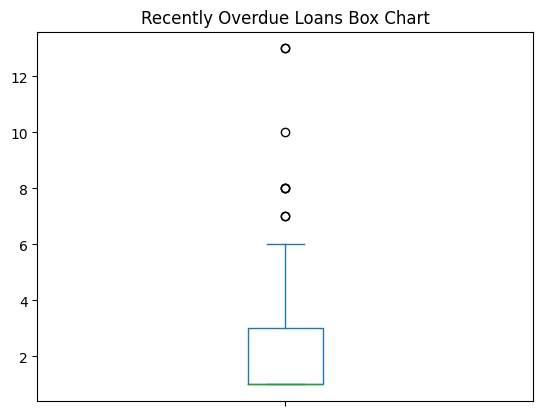

In [192]:
# How are overdue items distributed across members?
overdue_per_member = overdue.groupby('Membership ID').size()
print(f'Members With Most Overdue Items: {overdue_per_member.sort_values(ascending=False).head(n=10)}\n')

# How many members are overdue, as a proportion of members with recent loans
print(f'{len(set(overdue['Membership ID'])) / len(set(loaned_recently['Membership ID'])):.2%} Of Members Have Very Overdue Loans\n')
# interesting - XX% of members never return their shit - more than the X% of loans not returned, meaning
# folks a few folks returning large item loans are tipping the scales.
overdue_per_member.plot.box(title="Recently Overdue Loans Box Chart")

In [ ]:
# Action items?
#
# * Verify phone number and email before making loans (can use MyTurn hacks and poll to notify on signup),
#   or a proof of address (a piece of mail with name that matches your ID).
# * Collect addresses. Not required but probably doesn't hurt and lets us do collections.
# * If you don't have a verifiable phone or email - how'd you sign up? You can provide a proof of address.
#
# Find someone to own calling and pestering people with overdue loans. We want to get this number 5x down (1 in
# 100 instead of 1 in 100).
#
# The "most items overdue list" is useful if triaging, but ideally we start with a process for new loans and
# work our way through the backlog.

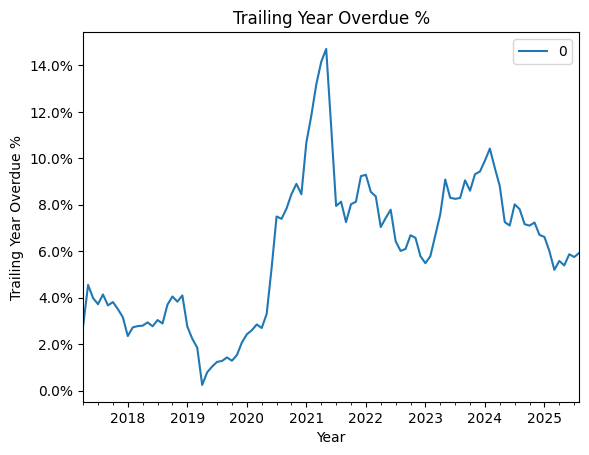

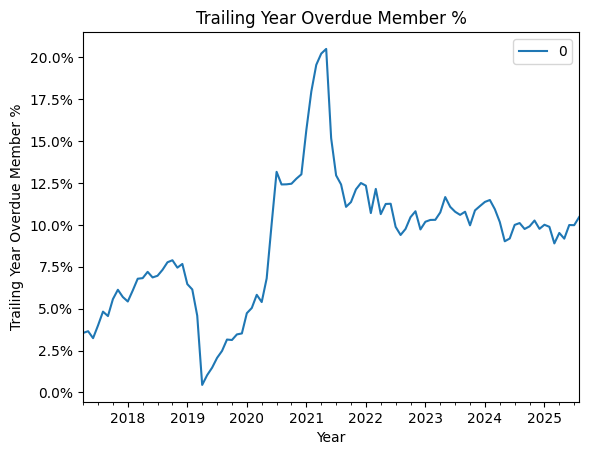

In [195]:
# Trailing 1 year return rate?
#
# We can look at historic loans and take a snapshot at each month of what proportion of loans made in the previous
# year + 3 months have been returned at that point.
#
# TODO: We want to count loans marked as returned but who's items have some 'Never Returned', 'Lost By Member' or other
# status as overdue. We can probably make a little helper that populates these values for items and can be reused.

from datetime import datetime, timedelta
import matplotlib.ticker as mtick

ix = pd.period_range(start="2017-04-01", end=datetime.now(),freq="M")
series = []
member_series = []
for p in ix:
    now = p.start_time
    year_and_3_months_before = now - timedelta(weeks=65)
    three_months_before = now - timedelta(weeks=13)

    trailing_year = loans[(loans['Checked Out'] >= year_and_3_months_before) & (loans['Checked Out'] < three_months_before)]
    overdue = trailing_year[trailing_year['Checked In'].isna() | (trailing_year['Checked In'] > now)]
    series.append(len(overdue)/len(trailing_year))
    member_series.append(len(set(overdue['Membership ID'])) / len(set(trailing_year['Membership ID'])))

graph = pd.DataFrame(series, index=ix).plot(title="Trailing Year Overdue %", xlabel="Year", ylabel="Trailing Year Overdue %")
graph.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
member_graph = pd.DataFrame(member_series, index=ix).plot(title="Trailing Year Overdue Member %", xlabel="Year", ylabel="Trailing Year Overdue Member %")
member_graph.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

In [ ]:
# Try to find item descriptions or admin notes that indicate they're lost but aren't in item description
set(items[
    (items['Description'].str.contains('return', case=False) | items['Description'].str.contains('lost', case=False) | items['Description'].str.contains('stolen', case=False))
    & ~items['Lost By Member']]['Description']).union(
set(items[
    (items['Admin Notes'].str.contains('return', case=False) | items['Admin Notes'].str.contains('lost', case=False) | items['Admin Notes'].str.contains('stolen', case=False))
    & ~items['Lost By Member']]['Admin Notes']))